<a href="https://colab.research.google.com/github/YukiFujisawa/kaggle/blob/master/taitanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from sklearn import svm, metrics, preprocessing, model_selection #機械学習用のライブラリを利用
from sklearn.kernel_approximation import RBFSampler #カーネル近似用の関数
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# LightGBM
import lightgbm as lgb
import os

BASE_DIR = '/content/drive/My Drive/kaggle/taitanic'



In [0]:
## 関数：データ読み込みと準備
def read_data_frame(file_name):

  # train.csvを読み込んで、扱いやす良いように"male", "femail"を0, 1に変換する
  training_data_frame= pd.read_csv(BASE_DIR + '/' + file_name).replace("male",0).replace("female",1)

  # Ageにはいくつか欠損してるレコードがある
  # 欠損しているところは中央値を当てはめるようにする
  # training_data_frame.fillnaは、空白のセルを埋めてくれる関数
  training_data_frame["Age"].fillna(training_data_frame.Age.mean(), inplace=True)
  training_data_frame["Fare"].fillna(training_data_frame.Fare.mean(), inplace=True)
  # training_data_frame['Generation'] = 0

  # 乗船料をパーセントランクする
  training_data_frame['FareRank'] = 0.0
  training_data_frame['Generation'] = 0.0
  training_data_frame['FamilySizeRank'] = 0.0
  training_data_frame['PctFareRank'] = training_data_frame['Fare'].rank(pct=True)
  training_data_frame["FamilySize"] = training_data_frame["SibSp"] + training_data_frame["Parch"] + 1

  # 年代を追加
  for index, row in training_data_frame.iterrows():
    if row["Age"] <= 15:
      training_data_frame.at[index, "Generation"] = 2.0
    elif row["Age"] <= 60:
      training_data_frame.at[index, "Generation"] = 3.0
    else:
      training_data_frame.at[index, "Generation"] = 4.0
   
    if row["PctFareRank"] <= 0.3:
      training_data_frame.at[index, "FareRank"] = 3.0
    elif row["PctFareRank"] <= 0.8:
      training_data_frame.at[index, "FareRank"] = 2.0
    else:
      training_data_frame.at[index, "FareRank"] = 1.0
    
    if row["FamilySize"] <= 1:
      training_data_frame.at[index, "FamilySizeRank"] = 1.0
    elif row["FamilySize"] <= 4:
      training_data_frame.at[index, "FamilySizeRank"] = 2.0
    else:
      training_data_frame.at[index, "FamilySizeRank"] = 3.0
  
  training_data_frame['FareRank'] = training_data_frame['FareRank'].astype(float)
  training_data_frame['Generation'] = training_data_frame['Generation'].astype(float)
  training_data_frame['FamilySizeRank'] = training_data_frame['FamilySizeRank'].astype(float)

  return training_data_frame.drop(["Name", 
                                   "SibSp", 
                                   "Parch", 
                                   "Ticket", 
                                   "Cabin", 
                                   "Fare",
                                   "Embarked",
                                   "Age", 
                                   "FamilySize", 
                                   "PctFareRank",
                                   ], axis=1, )



In [0]:
# 関数：ランダムフォレスト
def random_forest(xs, y):

  #　ランダムフォレストを選択する
  # http://neuro-educator.com/ml6/
  # n_estimatorsはパラメータ。
  # 40種類のパラメータがあるのでそれを調整するのがデータエンジニアの仕事
  model = RandomForestClassifier(n_estimators = 1000)

  # 学習してモデルを作成する
  # 原因（xs） => 結果（y）の因果関係をランダムフォレストで学習する
  # y: Survived

  return model.fit(xs, y)

In [0]:
# 関数：LightGBM
def lightgbm(xs, y):
  model = lgb.LGBMClassifier()
  return model.fit(xs, y)

In [0]:
# 関数：カーネルSVN
def kernel_svn(xs, y):

  # パラメータを dict 型で指定
  param_grid = {'C': [1, 10, 100, 1000],  'gamma' : [0.001, 0.01, 0.1, 1, 10]}
  grid_search = GridSearchCV(svm.SVC(kernel='rbf', random_state=0), param_grid, cv=5)
  grid_search.fit(xs, y)

  return grid_search.best_estimator_
  # clf_result=svm.SVC(kernel='rbf', gamma=1.0 , C=100.0,class_weight='balanced', random_state=0)
  # return clf_result.fit(xs, y)

In [0]:
# 関数：モデル学習
def fit(model_id, xs, survived_list):

  if model_id == 1:
    return random_forest(xs, survived_list)
  elif model_id == 2:
    return kernel_svn(xs, survived_list)
  else:
    return lightgbm(xs, survived_list)

In [89]:
## START メイン処理

training_data_frame = read_data_frame('train.csv')
training_data_array = training_data_frame.values

# トレーニングデータ（原因）
xs = training_data_array[:, 2:] 

# トレーニングデータ（結果）
# [Survived]
survived_list = training_data_array[:, 1] 

# モデルIDの定義
MODEL_RANDOM_FOREST = 1
MODEL_KERNEL_SVN = 2
MODEL_LGB = 3

# 学習
clf_result = fit(MODEL_LGB, xs, survived_list)

# 予測
predict_survived_list = clf_result.predict(xs)

# 正答率の計算
ac_score=metrics.accuracy_score(survived_list, predict_survived_list)
print("MODEL_KERNEL_SVN = ",ac_score)

# 学習
# clf_result = fit(MODEL_RANDOM_FOREST, xs, survived_list)

# 予測
# predict_survived_list = clf_result.predict(xs)

# 正答率の計算
# ac_score=metrics.accuracy_score(survived_list, predict_survived_list)
# print("MODEL_RANDOM_FOREST = ",ac_score)


MODEL_KERNEL_SVN =  0.8383838383838383


In [0]:
# テスト実行と予測結果

test_data_frame = read_data_frame('test.csv')

# ndarrayへの変換
test_data = test_data_frame.values

# test_data[:, 1:] = [[Pclass,Sex,Age,FamilySize]]
# predict_survived_list = [Survived]
predict_survived_list = clf_result.predict(test_data[:, 1:])

# test_data[:, 1:] = [PassengerID]
test_passenger_ids = test_data[:,0].astype(int)

# 予測結果
# predict_ = [[PassengerID, Survived]]
predict_results = list(
    zip(test_passenger_ids, predict_survived_list)
)

In [0]:
## 予測結果のCSV出力

import csv

# 予想した結果をpredict_result_data.csvに出力します
# PassengerId, Survived
# 
with open(BASE_DIR + "/predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_data[:,0].astype(int), predict_survived_list.astype(int)):
        writer.writerow([pid, survived])



## zipについて。
## イテラブルオブジェクト（リストやタプルなど）の要素を同時に取得して使いたい場合は、
## zip()関数を使う。以下、使用例
#
# names = ['Alice', 'Bob', 'Charlie']
# ages = [24, 50, 18]
#
# for name, age in zip(names, ages):
#   print(name, age)
#=>  Alice 24
#=>  Bob 50
#=>   Charlie 18

ここからデータ分析

FamilySizeRank： 家族数をランク分類したもの

FareRank： 運賃をランク分類したもの

Generation：年代をランク分類したもの

([array([374., 123.,  52.]), array([537., 292.,  62.])],
 array([1.        , 1.66666667, 2.33333333, 3.        ]),
 <a list of 2 Lists of Patches objects>)

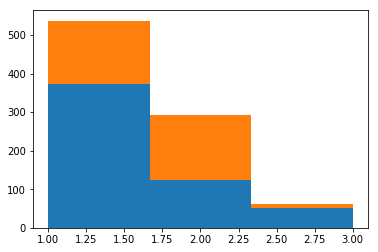

In [48]:
split_data = []
for survived in [0,1]:
  split_data.append(training_data_frame[training_data_frame.Survived==survived])

plt.hist(
    [i["FamilySizeRank"].dropna() for i in split_data], 
    histtype="barstacked", bins=3
)

([array([179., 156., 121.,  93.]), array([223., 224., 222., 222.])],
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 2 Lists of Patches objects>)

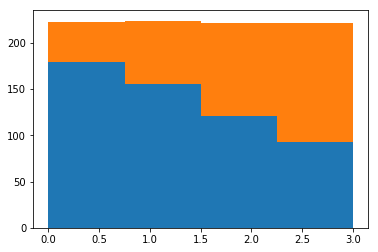

In [71]:
plt.hist(
    [i["FareRank"].dropna() for i in split_data], 
    histtype="barstacked", bins=4
)

([array([ 13.,  16.,  23.,  92., 209.,  62.,  45.,  37.,  18.,  15.,  12.,
           6.,   1.,   0.]),
  array([ 44.,  24.,  45., 134., 314., 113.,  75.,  53.,  39.,  24.,  18.,
           6.,   1.,   1.])],
 array([ 0.        ,  0.92857143,  1.85714286,  2.78571429,  3.71428571,
         4.64285714,  5.57142857,  6.5       ,  7.42857143,  8.35714286,
         9.28571429, 10.21428571, 11.14285714, 12.07142857, 13.        ]),
 <a list of 2 Lists of Patches objects>)

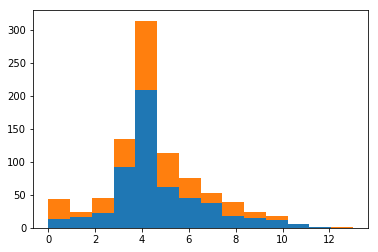

In [58]:
plt.hist(
    [i["Generation"].dropna() for i in split_data], 
    histtype="barstacked", bins=14
)